In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
import time

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

In [146]:
class SGD_test(Optimizer):
  """Stochastic gradient descent optimizer.

  Includes support for momentum,
  learning rate decay, and Nesterov momentum.

  Arguments:
      lr: float >= 0. Learning rate.
      momentum: float >= 0. Parameter that accelerates SGD in the relevant
        direction and dampens oscillations.
      decay: float >= 0. Learning rate decay over each update.
      nesterov: boolean. Whether to apply Nesterov momentum.
  """

  def __init__(self, lr=0.01, momentum=0., decay=0., nesterov=False, **kwargs):
    super(SGD_test, self).__init__(**kwargs) # für alle Optimizer gleich, SGD vom Namen der Klasse
    with K.name_scope(self.__class__.__name__): # Prefix self.__class__.__name__
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.lr = K.variable(lr, name='lr')
      self.momentum = K.variable(momentum, name='momentum')
      self.decay = K.variable(decay, name='decay')
    self.initial_decay = decay
    self.nesterov = nesterov # hier werden nur lauter Attribute definiert

  def _create_all_weights(self, params): # Gewichte mit der richtigen Shape
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments
    return moments

  def get_updates(self, loss, params):
    grads = self.get_gradients(loss, params)
    #print(grads[1][127])
    self.updates = [state_ops.assign_add(self.iterations, 1)] # das immer
    #print(self.iterations)
    #print(self.updates)

    lr = self.lr
    if self.initial_decay > 0:
      lr = lr * (  # pylint: disable=g-no-augmented-assignment
          1. /
          (1. +
           self.decay * math_ops.cast(self.iterations, K.dtype(self.decay))))
    # momentum
    moments = self._create_all_weights(params)
    #print(moments)
    for p, g, m in zip(params, grads, moments):
    
      v = self.momentum * m - lr * g  # velocity    # Gradient Descent Updates
      #print(v)  
      self.updates.append(state_ops.assign(m, v))  # das immer

      if self.nesterov:
        new_p = p + self.momentum * v - lr * g
      else:
        new_p = p + v
       
      #print(new_p)
      #print(p)
      #print(self.iterations)
      #print(self.updates)

      # Apply constraints.
      if getattr(p, 'constraint', None) is not None:
        new_p = p.constraint(new_p)
        
      self.updates.append(state_ops.assign(p, new_p))    # das immer
    return self.updates

  def get_config(self):      # das immer auf diese Art
    config = {
        'lr': float(K.get_value(self.lr)),
        'momentum': float(K.get_value(self.momentum)),
        'decay': float(K.get_value(self.decay)),
        'nesterov': self.nesterov
    }
    base_config = super(SGD_test, self).get_config()     # das immer
    return dict(list(base_config.items()) + list(config.items()))  # das immer

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 0s 169us/sample - loss: 2.1335 - accuracy: 0.2660 - val_loss: 1.8328 - val_accuracy: 0.4620
Epoch 2/5
1000/1000 [==============================] - 0s 169us/sample - loss: 1.4683 - accuracy: 0.6140 - val_loss: 1.2332 - val_accuracy: 0.6600
Epoch 3/5
1000/1000 [==============================] - 0s 232us/sample - loss: 0.8960 - accuracy: 0.7630 - val_loss: 0.8089 - val_accuracy: 0.7940
Epoch 4/5
1000/1000 [==============================] - 0s 216us/sample - loss: 0.5302 - accuracy: 0.8740 - val_loss: 0.6210 - val_accuracy: 0.8200
Epoch 5/5
1000/1000 [==============================] - 0s 169us/sample - loss: 0.3229 - accuracy: 0.9210 - val_loss: 0.5040 - val_accuracy: 0.8560
Overall calculation took 1.1716406345367432 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)

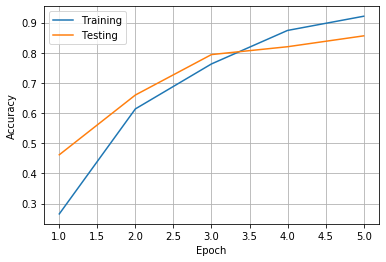

In [147]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                        optimizer = SGD_test())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [125]:
class SGD_EnKF(Optimizer):
  """Stochastic gradient descent optimizer.

  Includes support for momentum,
  learning rate decay, and Nesterov momentum.

  Arguments:
      lr: float >= 0. Learning rate.
      momentum: float >= 0. Parameter that accelerates SGD in the relevant
        direction and dampens oscillations.
      decay: float >= 0. Learning rate decay over each update.
      nesterov: boolean. Whether to apply Nesterov momentum.
  """

  def __init__(self, h_0 = 2, **kwargs):
    super(SGD_EnKF, self).__init__(**kwargs) # für alle Optimizer gleich, SGD vom Namen der Klasse
    with K.name_scope(self.__class__.__name__): # Prefix self.__class__.__name__
      self.iterations = K.variable(0, dtype='int64', name='iterations')
      self.h_0 = K.variable(h_0, name = "h_0")  
        
  def _create_all_weights(self, params): # Gewichte mit der richtigen Shape
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments
    return moments

  def get_updates(self, loss, params):
    grads = self.get_gradients(loss, params)
    self.updates = [state_ops.assign_add(self.iterations, 1)] # das immer

    h_0 = self.h_0
    
    # momentum
    moments = self._create_all_weights(params)
    for p, g, m in zip(params, grads, moments):
      v = m - h_0 * g  # velocity    # Gradient Descent Updates
      self.updates.append(state_ops.assign(m, v))  # das immer
        
      new_p = p + v

      # Apply constraints.
      if getattr(p, 'constraint', None) is not None:
        new_p = p.constraint(new_p)

      self.updates.append(state_ops.assign(p, new_p))    # das immer
    return self.updates

  def get_config(self):      # das immer auf diese Art
    config = {
        "h_0": float(K.get_value(self.h_0)),
    }
    base_config = super(SGD_EnKF, self).get_config()     # das immer
    return dict(list(base_config.items()) + list(config.items()))  # das immer

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 1s 521us/sample - loss: nan - accuracy: 0.1130 - val_loss: nan - val_accuracy: 0.1120
Epoch 2/5
1000/1000 [==============================] - 0s 423us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 3/5
1000/1000 [==============================] - 0s 398us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 4/5
1000/1000 [==============================] - 0s 383us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Epoch 5/5
1000/1000 [==============================] - 0s 444us/sample - loss: nan - accuracy: 0.1110 - val_loss: nan - val_accuracy: 0.1120
Overall calculation took 2.7660717964172363 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)   

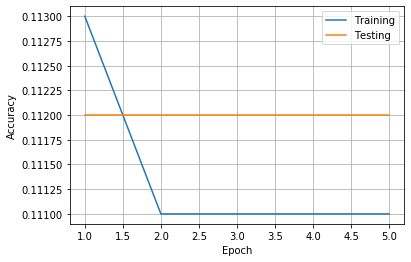

In [44]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                        optimizer = SGD_EnKF())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")

In [45]:
class COCOB(Optimizer):
    """Coin Betting Optimizer from the paper:
        https://arxiv.org/pdf/1705.07795.pdf
    """
    def __init__(self, alpha=100, **kwargs):
        """
        Initialize COCOB Optimizer
        Args:
            alpha: Refer to paper.
        """
        super(COCOB, self).__init__(**kwargs)
        self._alpha = alpha
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            
    def get_updates(self, params, loss, contraints=None):
        
        self.updates = [K.update_add(self.iterations, 1)]
        grads = self.get_gradients(loss, params)
        shapes = [K.int_shape(p) for p in params]
        L = [K.variable(np.full(fill_value=1e-8, shape=shape)) for shape in shapes]
        reward = [K.zeros(shape) for shape in shapes]
        tilde_w = [K.zeros(shape) for shape in shapes]
        gradients_sum = [K.zeros(shape) for shape in shapes]
        gradients_norm_sum = [K.zeros(shape) for shape in shapes]
        
        for p, g, li, ri, twi, gsi, gns in zip(params, grads, L, reward,
                                             tilde_w,gradients_sum,
                                               gradients_norm_sum):
            grad_sum_update = gsi + g
            grad_norm_sum_update = gns + K.abs(g)
            l_update = K.maximum(li, K.abs(g))
            reward_update = K.maximum(ri - g * twi, 0)
            new_w = - grad_sum_update / (l_update * (K.maximum(grad_norm_sum_update + l_update, self._alpha * l_update))) * (reward_update + l_update)
            param_update = p - twi + new_w
            tilde_w_update = new_w            
            
            self.updates.append(K.update(gsi, grad_sum_update))
            self.updates.append(K.update(gns, grad_norm_sum_update))
            self.updates.append(K.update(li, l_update))
            self.updates.append(K.update(ri, reward_update))
            self.updates.append(K.update(p, param_update))
            self.updates.append(K.update(twi, tilde_w_update))
            
            return self.updates
        
    def get_config(self):

        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(COCOB, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 1s 569us/sample - loss: 1.4419 - accuracy: 0.5480 - val_loss: 1.0290 - val_accuracy: 0.7200
Epoch 2/5
1000/1000 [==============================] - 1s 584us/sample - loss: 0.6516 - accuracy: 0.8170 - val_loss: 0.7731 - val_accuracy: 0.8240
Epoch 3/5
1000/1000 [==============================] - 1s 516us/sample - loss: 0.3688 - accuracy: 0.9210 - val_loss: 0.6527 - val_accuracy: 0.8320
Epoch 4/5
1000/1000 [==============================] - 0s 467us/sample - loss: 0.2216 - accuracy: 0.9680 - val_loss: 0.6057 - val_accuracy: 0.8420
Epoch 5/5
1000/1000 [==============================] - 0s 481us/sample - loss: 0.1518 - accuracy: 0.9800 - val_loss: 0.5833 - val_accuracy: 0.8440
Overall calculation took 3.528202533721924 seconds.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense) 

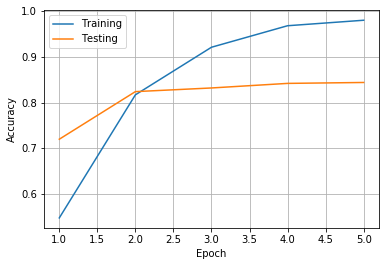

In [46]:
model = nn_model_structure(layers = 5,
                           neurons = [128, 128, 64, 32, 10],
                           n_cols = X_train_small.shape[1])
model = nn_model_compile(model,
                        optimizer = COCOB())
start_time = time.time()
model = nn_model_fit(model,
                     X_train = X_train_small,
                     y_train = y_train_small,
                     X_val = X_val_small,
                     y_val = y_val_small,
                     batch_size = 10,
                     epochs = 5)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_acc(model)
# nn_save(model, "../models/model_test_small.h5")